<h3><center>Introduction to building a quant pricing library</center></h3>
<h1><center>Option Pricing by Partial Differential Equation using OOP</center></h1>
<h3><center>Abdulwahab, Animoku</center></h3>
<h4><center>18 October, 2023</center></h4>



## Option Pricing by PDE

<b>Goal of option pricing via PDE:<b>

* Use the Black Scholes PDE to price European Contract
* Use  different discretization scheme to achieve better results
* Compare the solution to the Analytical Pricer
* Price American Option with PDE method


<b>Extension<b>
* Calculate Greeks based on the different Schemes
* Extend PDE pricing scheme to Forward<b>

# Steps to achieve our Objectives
* Create Market Model
* Create European Contract using market inputs (underlying, Call/Put, Long/Short, strike, expiry)
* Create PDEParams using $dS, dt, S_{min_{multiplier}}, S_{max_{multiplier}} $ and method (implicit, explicit, CrankNicolson) as inputs
* Create EuropeanPDEPricer using the contract, model and PDEParams
* Calculate FV
* Visualize the Call and Put prices in 2D

In [20]:
import matplotlib.pyplot as plt

to_plot = [ {'data': [[0]*6, list(range(6))],
             'color':'r',
             'title':'Our interests'},
           {'data': [list(range(6))+[5]*6+list(range(6)), [0]*6+list(range(6))+[5]*6],
            'color' : 'g',
            'title' : 'Boundary and initial conditions'
           },] + [
           {'data': [[i]*6, list(range(6))],
            'color' : 'g',
            'title' : f'Step {5-i}'
           } for i in range(4,-1,-1)]
           

def my_illustration_plot(to_plot):
    fig,ax = plt.subplots(1)
    for x in to_plot:
        plt.scatter(*x['data'], s=300, c=x['color'])
        plt.title(x['title'])
#         plt.axis('on')
        plt.xlim(-1,6)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlabel("Time")
    plt.ylabel("Stock")
    plt.show()
    

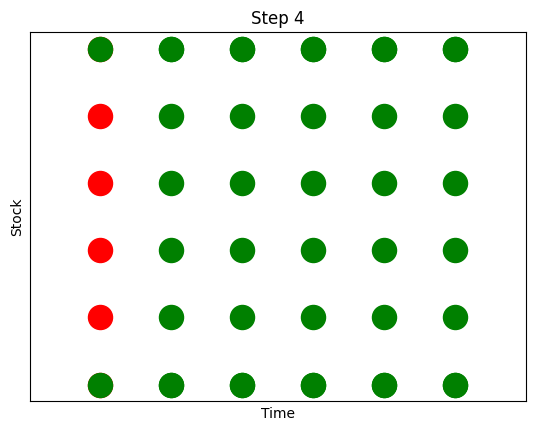

In [21]:
my_illustration_plot(to_plot[:6])

## Call and Put Option Pricing for European Options via PDE

Recall that the value $V$ of a Europoean option at time $t$, written on an underlying asset with price $S,$ satisfies the Black-Scholes equation
  $$ \frac{\delta V}{\delta t} + \frac{1}{2}\sigma^2 S^2\frac{\delta V^2}{\delta S^2} + rS \frac{\delta V}{\delta S} - rV =0,$$
 
with suitable terminal and boundary conditions:
$$V_C(S,T) = \max \{S-K,0 \}$$
$$V_P(S,T) = \max \{K-S,0 \}.$$
$$V_C(S_{\min}, t) = 0, V_C(S_{\max}, t) = S_{\max}- Ke^{-r(T-t)}, $$
$$V_P(S_{\max}, t) = 0, V_P(S_{\min}, t) = Ke^{-r(T-t)}-S_{\min}. $$

In [22]:
# Add current folder and QuantCourseBP folder to syspath to import modules
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

current = Path(Path().resolve())
sys.path.append(str(current))
sys.path.append(str(current.parents[1]))

from src.enums import *
from src.utils import *
from src.market_data import *
from src.pricer import *
# Make charts interactive
%matplotlib notebook

# Initialize market data
MarketData.initialize()

# Utility function

In [23]:
"""The pricing function of European call option"""
def black_scholes_eur_call(spot, time_to_mat,sigma, strike, rate):
    d1_vec = ( np.log( spot / strike ) + ( rate + 0.5 * sigma**2 ) * time_to_mat ) / ( sigma * time_to_mat**0.5 )
    d2_vec = d1_vec - sigma * time_to_mat**0.5

    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)

    return N_d1_vec * spot - strike * np.exp((-1.0)*rate*time_to_mat) * N_d2_vec

# Create Test Example Contracts

In [24]:
und = Stock.TEST_COMPANY
expiry = 2.0
strike = 0.95 * MarketData.get_spot()[und]
ls = LongShort.LONG

In [25]:
derivative_type = [PutCallFwd.CALL, PutCallFwd.PUT]
model_types = [BSVolModel(und), FlatVolModel(und)]

contracts=[EuropeanContract(und, deriv_type, ls, strike, expiry) for deriv_type in derivative_type]
analytic_pricer = [EuropeanAnalyticPricer(contract, model_type, Params()) for contract in contracts for model_type in model_types]
analytical_fv= [pricer.calc_fair_value() for pricer in analytic_pricer]

print(f"FairValues:{analytical_fv}")

FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


# Example with Explicit Method

* Create European Contract
* Create Market Model
* Create PDEParam
* Create EuropeanPDEPricer
* Calculate FV based on Explicit method
* Visualize the Call or Put prices in 2D 

In [28]:
params_exp = PDEParams(method = BSPDEMethod.EXPLICIT)

pde_exp_pricer = [EuropeanPDEPricer(contract, model_type, params_exp) for contract in contracts for model_type in model_types]
pde_exp_fv= [pricer.calc_fair_value() for pricer in pde_exp_pricer]

# pde_exp_pricer = [GenericPDEPricer(contract, model_type, params_exp) for contract in contracts for model_type in model_types]
# pde_exp_fv= [pricer.calc_fair_value() for pricer in pde_exp_pricer]


In [29]:
print(f"PDE Explicit method FairValues:{pde_exp_fv}")
print(f"Analytical method FairValues:{analytical_fv}")

PDE Explicit method FairValues:[23.604447307816308, 19.559315913934707, 9.563828924282564, 5.518692809208318]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [7]:
Errors = [f"{(price1-price2)/price1 *100:.4f}%" for price1, price2 in zip(pde_exp_fv, analytical_fv)]
print(f"Error between the Analytical and PDE Explicit method FairValues:{Errors}")

Error between the Analytical and PDE Explicit method FairValues:['-0.0077%', '0.0018%', '-0.0209%', '0.0031%']


# Attributes needed to create visualization

In [8]:
und_step = pde_exp_pricer[0].und_step
time_step = pde_exp_pricer[0].time_step
s_min= pde_exp_pricer[0].stock_min
s_max=pde_exp_pricer[0].stock_max
sigma = pde_exp_pricer[0].bsPDE.sigma
spot = pde_exp_pricer[0].initial_spot
rate = pde_exp_pricer[0].interest_rate
num_of_und_steps = pde_exp_pricer[0].bsPDE.num_of_und_steps

# Plot the graph for the first contract for different S values

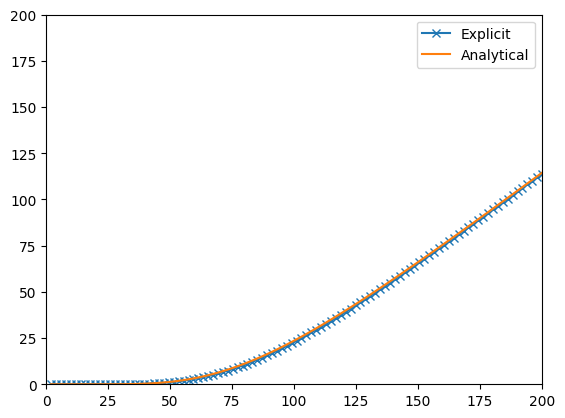

In [9]:
import matplotlib.pyplot as plt
sol_exp = pde_exp_pricer[0].grid[:,1]
Spots = np.linspace(s_min + und_step, s_max, num_of_und_steps+1)

%matplotlib inline
plt.plot(Spots, sol_exp, "x-", label="Explicit")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

# Example with Non-Convergence with Explicit Params

In [11]:
params_exp = PDEParams(und_step = 0.01, time_step=0.001, method = BSPDEMethod.EXPLICIT)

pde_exp_pricer = EuropeanPDEPricer(contracts[0], model_types[0], params_exp) 
pde_exp_fv= pde_exp_pricer.calc_fair_value()


C:\git\BSPDE\src\numerical_method.py:162: RuntimeWarning: overflow encountered in scalar add
  self.grid[i, j] = alpha[i] * self.grid[i - 1, j + 1] + beta[i] * self.grid[i, j + 1] + gamma[i] \
C:\git\BSPDE\src\numerical_method.py:162: RuntimeWarning: overflow encountered in scalar multiply
  self.grid[i, j] = alpha[i] * self.grid[i - 1, j + 1] + beta[i] * self.grid[i, j + 1] + gamma[i] \
C:\git\BSPDE\src\numerical_method.py:162: RuntimeWarning: invalid value encountered in scalar add
  self.grid[i, j] = alpha[i] * self.grid[i - 1, j + 1] + beta[i] * self.grid[i, j + 1] + gamma[i] \


In [12]:
print(f"PDE Explicit method FairValues:{pde_exp_fv}")

PDE Explicit method FairValues:nan


# Example with Implicit Method

* Create European Contract
* Create Market Model
* Create PDEParams
* Create EuropeanPDEPricer
* Calculate FV based on Implicit method
* Visualize the Call or Put prices in 2D

In [10]:
param_imp = PDEParams(method = BSPDEMethod.IMPLICIT)

pde_imp_pricer = [EuropeanPDEPricer(contract, model_type, param_imp) for contract in contracts for model_type in model_types]
pde_imp_fv= [pricer.calc_fair_value() for pricer in pde_imp_pricer]

In [11]:
print(f"PDE Implicit method FairValues:{pde_imp_fv}")
print(f"Analytical method FairValues:{analytical_fv}")

PDE Implicit method FairValues:[23.60198913553196, 19.557755216197634, 9.562097627250461, 5.5176052392037995]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [12]:
Errors_imp = [f"{(price1-price2)/price1 *100:.4f}%" for price1, price2 in zip(pde_imp_fv,analytical_fv)]
print(f"Error between the Analytical and PDE Explicit method FairValues:{Errors_imp}")

Error between the Analytical and PDE Explicit method FairValues:['-0.0182%', '-0.0062%', '-0.0390%', '-0.0166%']


# Compare Implicit Method with Analytical Pricer

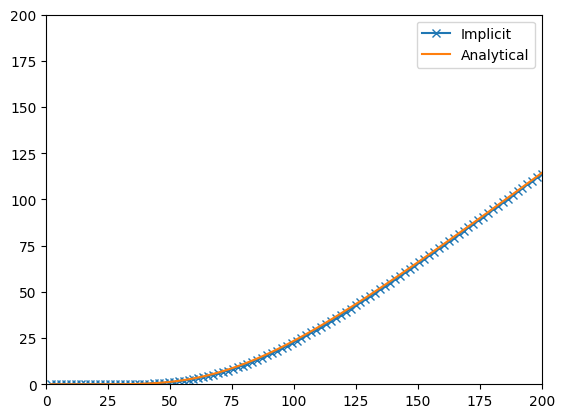

In [13]:
sol_imp = pde_imp_pricer[0].grid[:,1]


plt.plot(Spots, sol_imp, "x-", label="Implicit")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

# Example with Crank Nicolson Method

* Create European Contract
* Create Market Model
* Create PDEParams
* Create GenericPDEPricer
* Calculate FV and Greeks based on Crank_Nicolson methods
* Visualize the Call and Put prices in 2D and 3D

In [14]:
param_crn = PDEParams(method = BSPDEMethod.CRANK_NICOLSON)

pde_crn_pricer = [EuropeanPDEPricer(contract, model_type, param_crn) for contract in contracts for model_type in model_types]
pde_crn_fv= [pricer.calc_fair_value() for pricer in pde_crn_pricer]


In [15]:
print(f"PDE Crank-Nicolson method FairValues:{pde_crn_fv}")
print(f"Analytical method FairValues:{analytical_fv}")

PDE Crank-Nicolson method FairValues:[23.6034086340357, 19.558594355475716, 9.562963346249866, 5.518149067657358]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [16]:
Errors_crn = [f"{(price1-price2)/price1 *100:.4f}%" for price1, price2 in zip(pde_crn_fv,analytical_fv)]
print(f"Error between the Analytical and PDE Crank Nicolson method FairValues:{Errors_crn}")

Error between the Analytical and PDE Crank Nicolson method FairValues:['-0.0121%', '-0.0019%', '-0.0300%', '-0.0067%']


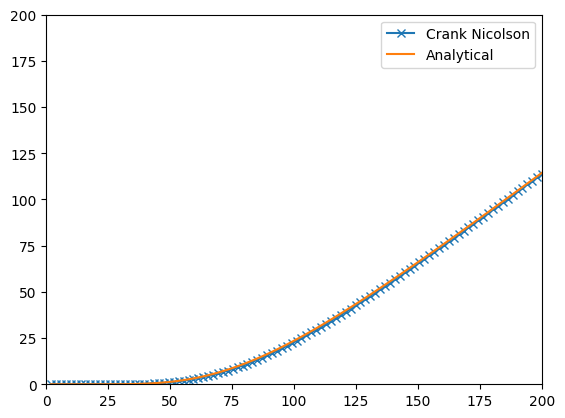

In [17]:
sol_imp = pde_crn_pricer[0].grid[:,1]

plt.plot(Spots, sol_imp, "x-", label="Crank Nicolson")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

# Pricing American Option with Black Scholes PDE

<b>Properties of American Option:<b>
* The price of an American Option is atleast as much as the European Option with the same properties:
  $V_t^{am} \geq V_t^{eur}, \ for \, any\, \;  t \in [0,T]$
* An American option has at least the value of the payoff at any time $t.$
* There are different numerical techniques to price an American Option: LongStaff-Schwarz, PDE, Tree methods 
* American Call contract will never be exercised early unless the stock has a dividend.
* For a sufficient Low Price an American Put will be exercised

<b>Consider the Porfolio:<b>
* Consider an American put has a value lower than $(K-S)^+$
Strategy:
* Take Long positions in both the Asset and in the money Put Option
* Exercise the Put option immediately and sell the stock at higher price K. 
* This creates an arbitrage opportunity until the Put price becomes at least the payoff.
* Thus,
$$V_{t,c}^{am} \geq \max(S_t - K,0), \ for \, any\, \;  t \in [0,T]$$
$$V_{t,p}^{am} \geq \max(K- S_t,0), \ for \, any\, \;  t \in [0,T]$$

In [14]:
params_exp = PDEParams(method = BSPDEMethod.EXPLICIT)
contracts=[AmericanContract(und, deriv_type, ls, strike, expiry) for deriv_type in derivative_type]

pde_exp_pricer = [AmericanPDEPricer(contract, model_type, params_exp) for contract in contracts for model_type in model_types]
pde_exp_fv= [pricer.calc_fair_value() for pricer in pde_exp_pricer]

In [15]:
print(f"PDE Explicit method FairValues:{pde_exp_fv}")

PDE Explicit method FairValues:[23.604447307816308, 19.559315913934707, 10.451567329616111, 6.281464959775393]


# Conclusion

* We have seen the implemention of European Call/Put options pricing via PDE methods
* Which method is faster?

<b> Project Ideas <b>

* Implement Forward pricing on the Grid
* Implement the Greeks using the bump and re-evaluation method